In [1]:
import os

os.sys.path.insert(0, '../script')

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from webnlg import WebNLGCorpus, DATASETS_FILEPATHS
%matplotlib inline

pd.set_option('max_colwidth', 1000)

import seaborn as sns

In [3]:
# datasets
DATASETS_FILEPATHS.keys()

dict_keys(['dev', 'train', 'test_no_lex', 'test_unseen_with_lex', 'test_with_lex'])

# Dataset format

## Train dataset directory tree

<img src="../img/dataset_train_directory.jpg" />

### 1triples_Airport_train_challenge.xml

<img src="../img/dataset_format_example.jpg" />

## Test dataset is all in one file, testdata_no_lex.xml

<img src="../img/dataset_test_example.jpg" />

# Dataset Stats

In [4]:
# loads datasets

train_dev = WebNLGCorpus.load(dataset=['train', 'dev'])
test_no_lex = WebNLGCorpus.load(dataset='test_no_lex')
test_unseen_with_lex = WebNLGCorpus.load(dataset='test_unseen_with_lex')

datasets = [train_dev, test_no_lex, test_unseen_with_lex]

In [6]:
# generate some statistics

datasets_stats = pd.DataFrame({
    # number of entries
    'n_entries': [len(ds) for ds in datasets],
    # number of distinct triples
    'n_distinct_triples': [ds.mdf.mtext.nunique() for ds in datasets],
    # number of distinct generated texts - if test_no_lex, returns 0
    'n_distinct_lexes': [ds.ldf.ltext.nunique() if ds.dataset != 'test_no_lex' else 0 for ds in datasets],
    # number of triples -> each entry can have up to 7 triples
    'n_triples': [len(ds.mdf) for ds in datasets],
    # average text length
    'avg_lexes_length': [ds.ldf.ltext.str.len().mean() if ds.dataset != 'test_no_lex' else 0 for ds in datasets]
    }, index=[ds.dataset for ds in datasets])

datasets_stats

,avg_lexes_length,n_distinct_lexes,n_distinct_triples,n_entries,n_triples
train_dev,117.367354,20308,2131,7812,23021
test_no_lex,0.000000,0,2331,1862,5378
test_unseen_with_lex,110.532676,2430,1068,891,2450


## Is there any duplicated lexicalized text?

Here I test if there are two or more different entries with the same lexicalization.

In [17]:
# group by ltext
#    counts uniques idx(entry identifier) inside a group
lexis_counts = train_dev.ldf.groupby('ltext').idx.unique().apply(len)

# some examples of lexicalizations that occur in different entries
lexis_counts.nlargest(5)

ltext
Barack Obama is the leader of the United States.                                                                    3
Joe Biden is a United States leader.                                                                                3
Joe Biden is a leader of the United States.                                                                         3
St Vincent-St Mary High School, Akron, Summit County, Ohio, United States is the ground of Akron Summit Assault.    3
103 Colmore Row was completed in 1976.                                                                              2
Name: idx, dtype: int64

In [21]:
print("There are {} lexicalizations that occurs in more than one entry. The ammount of 'duplicated' lexicalizations is {}"\
      .format(
        len(lexis_counts[lexis_counts > 1]), 
        lexis_counts[lexis_counts > 1].sum()
      ))

There are 58 lexicalizations that occurs in more than one entry. The ammount of 'duplicated' lexicalizations is 120


#### Let's analyze some example

In [29]:
# gets the idx of entrys which lexicalization is Barack Obama is the leader of the United States.
barack_obama_idx = train_dev.ldf[train_dev.ldf.ltext == 'Barack Obama is the leader of the United States.'].idx

# prints those entries

for idx in barack_obama_idx:
    
    print(train_dev.sample(idx=idx))
    print('\n\n---------------------------------------------------------------------------------------\n\n')

Triple info: {'category': 'Building', 'eid': 'Id232', 'idx': '3_231', 'ntriples': 1}

	Modified triples:

United_States | leaderName | Barack_Obama


	Lexicalizations:

The leader of the United States was Barack Obama.
Barack Obama is the leader of the U.S.
Barack Obama is the leader of the United States.


---------------------------------------------------------------------------------------


Triple info: {'category': 'WrittenWork', 'eid': 'Id211', 'idx': '4_210', 'ntriples': 1}

	Modified triples:

United_States | leaderName | Barack_Obama


	Lexicalizations:

The leader of the United States is Barack Obama.
Barack Obama is the leader of the United States.
Barack Obama is the president of the US.


---------------------------------------------------------------------------------------


Triple info: {'category': 'Food', 'eid': 'Id267', 'idx': '5_266', 'ntriples': 1}

	Modified triples:

United_States | leaderName | Barack_Obama


	Lexicalizations:

Barack Obama is a leader of the U

<img src="../img/barack_obama_food.jpg" />

Is Barack Obama a Food? I've sent an e-mail to Anastasia Shimorina.

<img src="../img/barack_obama_food_explanation.jpg" />

One example of entry among the Food category that contains the triple United_States | leader | Barack_Obama:

<img src="../img/barack_obama_food2.jpg" />

So, every triple in the Xtriplesize_category, X > 1, is in 1triplesize_category ?
    
Let's test.

! I'm putting dev and train together !

In [14]:
from config import CATEGORIES

for category in CATEGORIES:
    
    print("Testing category: [{}]".format(category))
    
    triple_1_entries = train_dev.subset(ntriples=[1], categories=[category]).mdf
    
    triple_gt1_entries = train_dev.subset(ntriples=[2, 3, 4, 5, 6, 7], categories=[category]).mdf
    
    not_in_triple1 = triple_gt1_entries[~triple_gt1_entries.mtext.isin(triple_1_entries.mtext)]
    
    print("Number of triples in X>1 tripleset that aren't in 1 tripleset: [{}]"\
          .format(len(not_in_triple1.mtext.unique())))
    if len(not_in_triple1):
        
        triple_sample = not_in_triple1.sample()
        print('Example of triple: ', triple_sample.mtext.values[0])
        sample = train_dev.sample(idx=triple_sample.idx.values[0])
        print('\n')
        print(sample)
        
    print('\n')

Testing category: [Airport]
Number of triples in X>1 tripleset that aren't in 1 tripleset: [38]
Example of triple:  Greenville,_Wisconsin | isPartOf | Grand_Chute,_Wisconsin


Triple info: {'category': 'Airport', 'eid': 'Id141', 'idx': '40_140', 'ntriples': 5}

	Modified triples:

Appleton_International_Airport | location | Greenville,_Wisconsin
Greenville,_Wisconsin | isPartOf | Grand_Chute,_Wisconsin
Greenville,_Wisconsin | isPartOf | Menasha_(town),_Wisconsin
Greenville,_Wisconsin | country | United_States
Appleton_International_Airport | cityServed | Appleton,_Wisconsin


	Lexicalizations:

Appleton International airport, which serves the city of Appleton (Wisconsin), is located in Greenville, Wisconsin, in the United States. Greenville is part of both Grand Chute and Menasha, both in Wiconsin.
Appleton International Airport can be found in Greenville, Wisconsin which is part of Grand Chute,Wisconsin,United States.The airport serves Appleton,Wisconsin and Greenville is part of Mena

Number of triples in X>1 tripleset that aren't in 1 tripleset: [24]
Example of triple:  Above_the_Veil | author | Garth_Nix


Triple info: {'category': 'WrittenWork', 'eid': 'Id122', 'idx': '51_121', 'ntriples': 3}

	Modified triples:

Above_the_Veil | author | Garth_Nix
Above_the_Veil | OCLC_number | 46451790
Above_the_Veil | mediaType | Hardcover


	Lexicalizations:

Above the Veil, written by Garth Nix, is available in hardcover and has the OCLC number 46451790.
Above the Veil (OCLC number 46451790) is available in hardcover and written by Garth Nix.
Above the Veil by Garth Nix is available in hardcover with the OCLC number 46451790.




So, there are triples in X>1 triplesets datasets wich doesn't occur in the respective 1 tripleset dataset, of the same category.

### And what about if all triples in Xtriple set are in 1triple set?

In [16]:
triple_1 = train_dev.subset(ntriples=[1]).mdf
triples_gt1 = train_dev.subset(ntriples=[2, 3, 4, 5, 6, 7]).mdf

in_gt1_not_1 = triples_gt1[~triples_gt1.mtext.isin(triple_1.mtext)]

print("There are {} triples in X>1 datasets that aren't in 1 datasets"\
      .format(len(in_gt1_not_1)))

There are 2128 triples in X>1 datasets that aren't in 1 datasets


In [21]:
sample = in_gt1_not_1.sample()

print('Triple: {}'.format(sample.mtext.values[0]))

print('\n')

print(train_dev.sample(idx=sample.idx.values[0]))

Triple: Alcatraz_Versus_the_Evil_Librarians | country | United_States


Triple info: {'category': 'WrittenWork', 'eid': 'Id171', 'idx': '51_170', 'ntriples': 3}

	Modified triples:

Alcatraz_Versus_the_Evil_Librarians | language | English_language
United_States | ethnicGroup | Asian_Americans
Alcatraz_Versus_the_Evil_Librarians | country | United_States


	Lexicalizations:

Written in English, the book Alcatraz Versus the Evil Librarians is from The United States where one of the ethnic groups is Asian Americans.
The US is home to Asian Americans and the origin place of Alcatraz Versus the Evil Librarians.
Alcatraz Versus the Evil Librarians was written in English and comes from the United States where one of the ethnic groups are the Asian Americans.


So, there are triples in X>1 datasets that don't occur in 1 datasets at all. This impacts my approach of generating templates with 1 datasets only :)

## Distribution per category and number of triples

In [22]:
def heatmap_by_category_ntriples(ds):
    
    # makes a figure
    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    # heatmap of counts per category x ntriples
    sns.heatmap(pd.crosstab(ds.category, ds.ntriples), 
                # annotate counts
                annot=True,
                ax=ax,
                # integer formatting
                fmt='d',
                cmap='Blues')

### train_dev

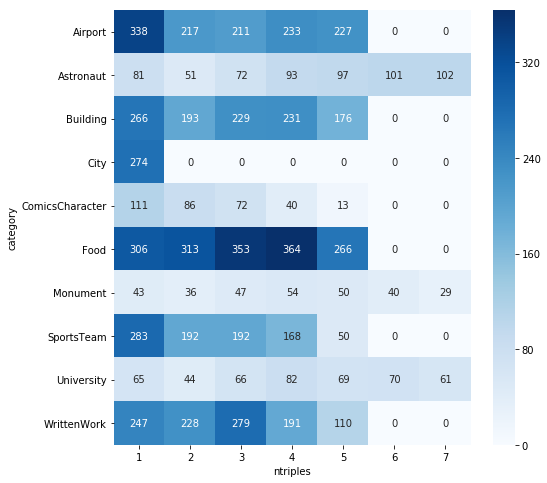

In [24]:
heatmap_by_category_ntriples(train_dev.edf)

### test_no_lex

there are categories on test that there aren't on train, like Artist

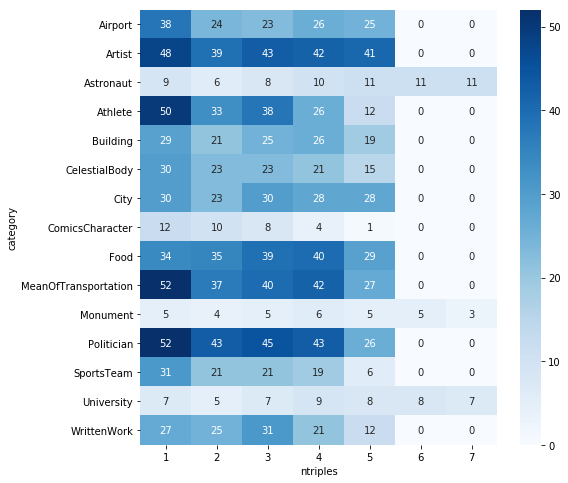

In [25]:
heatmap_by_category_ntriples(test_no_lex.edf)

### test_unseen_with_lex

unseen categories

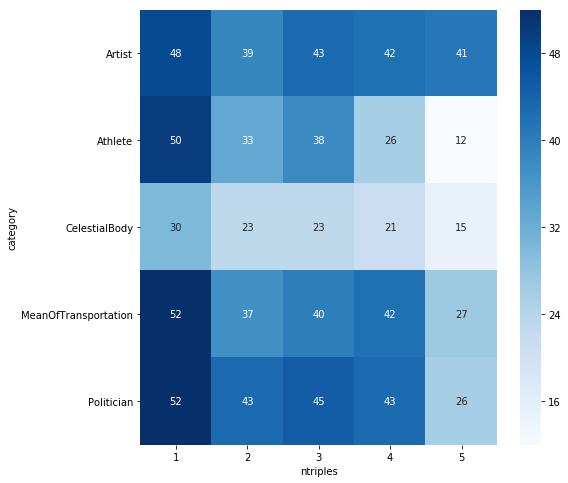

In [26]:
heatmap_by_category_ntriples(test_unseen_with_lex.edf)

# Have a look at a sample

In [27]:
train_dev.sample(category='Astronaut', ntriples=1, random_state=100)

Triple info: {'category': 'Astronaut', 'eid': 'Id12', 'idx': '7_11', 'ntriples': 1}

	Modified triples:

Alan_Shepard | birthDate | "1923-11-18"


	Lexicalizations:

Alan Shepard was born November 18th, 1923.
Alan Shepard was born on November 18, 1923.
Alan Shepard was born on Nov 18, 1923.
Alan Shepard was born on 1923-11-18.
Alan Shepard was born on the 18th of November 1923.

In [28]:
test_no_lex.sample(category='Astronaut', ntriples=1, random_state=100)

Triple info: {'category': 'Astronaut', 'eid': 'Id139', 'idx': '0_138', 'ntriples': 1}

	Modified triples:

Apollo_8 | backup pilot | Buzz_Aldrin


# Is there any duplicates?

## Is there any modified triple duplicated in a tripleset?

No

In [30]:
# count how many entries has duplicated mtriples among its mtriples
def n_duplicated_mtriples_per_entry(ds):
    
    # group by
    #    idx, mtext -> if there is a group with more than 1 element
    #       it means that there are duplicateds mtext(mtext) in a tripleset(idx)
    mtriples_count_per_entry = ds.mdf.groupby(['idx', 'mtext']).size()
    
    # sum(true = 1 false = 0) the cases of duplications
    return (mtriples_count_per_entry > 1).sum()

In [31]:
pd.Series({dataset.dataset: n_duplicated_mtriples_per_entry(dataset)
             for dataset in datasets},
          name='number of cases of triples duplicated in a tripleset')

test_no_lex             0
test_unseen_with_lex    0
train_dev               0
Name: number of cases of triples duplicated in a tripleset, dtype: int64

## Is there any modified triple duplicated among all entries?

yes

In [32]:
# counts, for each mtriple, in how many entries it occurs
def mtriples_count(ds):
    
    return ds.mdf.mtext.value_counts()

def mtriples_count_describe(ds):
    
    s = mtriples_count(ds).describe()
    s.name = ds.dataset
    
    return s

In [33]:
# ex: on average, each triple of train_dev dataset occurs in 10.8 entries
#     on maximum, 123 times
pd.concat([mtriples_count_describe(ds) for ds in datasets], axis=1)

,train_dev,test_no_lex,test_unseen_with_lex
count,2131.000000,2331.000000,1068.000000
mean,10.802909,2.307164,2.294007
std,13.211164,2.216992,1.641108
min,1.000000,1.000000,1.000000
25%,3.000000,1.000000,1.000000
50%,7.000000,2.000000,2.000000
75%,13.000000,3.000000,3.000000
max,123.000000,39.000000,10.000000


In [34]:
# most frequent triples in train dataset

cm_train = mtriples_count(train_dev)

cm_train.head(3)

English_language | spokenIn | Great_Britain    123
United_States | capital | Washington,_D.C.     105
United_States | language | English_language    102
Name: mtext, dtype: int64

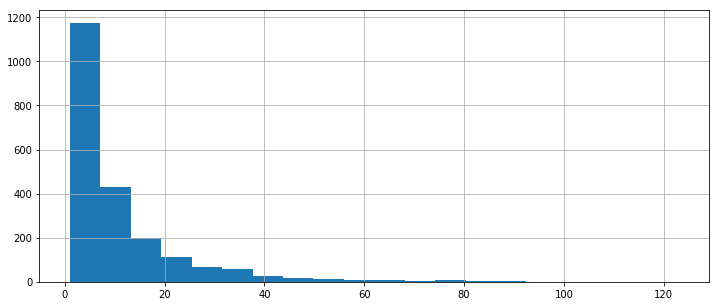

In [45]:
mtriples_count(train_dev).hist(bins=20, figsize=(12, 5))

## Are entries with shared triples lexicalized the same way?

Remember that the same triple can appear in more than one entry.

There are some patterns...

In [48]:
# groups by mtext and lists the lexicalizations
def mtriples_with_generated_lexes(ds):
    
    # merges modified triple dataset and lexicalization dataset
    df = pd.merge(ds.mdf, ds.ldf)
    
    # groups by triple and for each triple generates a list of lexicalizations
    ddf = df.groupby('mtext').ltext.apply(list).to_frame()
    # adds a column with the number of lexicalizations
    ddf['size'] = ddf.ltext.apply(len)
    
    return ddf

# prints triple and its lexicalizations
def print_mtriple_with_generated_lexes(mtriple):
    
    print("triple: ", mtriple.name, '\n')
    for ltext in mtriple.ltext:
        print("lexicalization: ", ltext, '\n')

### train_dev

For example: 

* *11_Diagonal_Street | floorArea | 1200 (square metres)* appears in entries with eids 3_14(size = 1) and 29_14(size = 4)

In [49]:
mtriples_w_lexes_train = mtriples_with_generated_lexes(train_dev)

In [50]:
# on average, each triple occurs in 28 lexicalizations
# on maximum, 319
mtriples_w_lexes_train['size'].describe()

count    2131.000000
mean       28.432191
std        34.977128
min         1.000000
25%         6.000000
50%        17.000000
75%        36.000000
max       319.000000
Name: size, dtype: float64

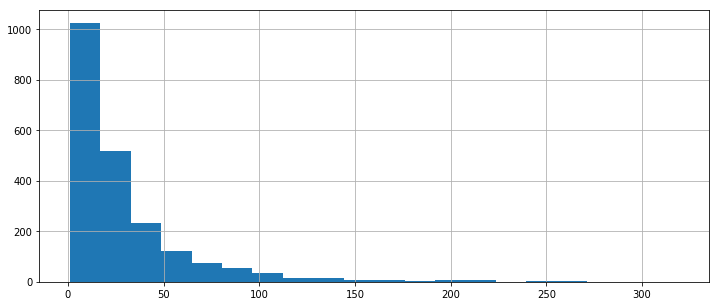

In [53]:
mtriples_w_lexes_train['size'].hist(bins=20, figsize=(12, 5))

In [54]:
# some examples of triples that are lexicalizad in more than one way
mtriples_w_lexes_train_size_lt_5 = mtriples_w_lexes_train[mtriples_w_lexes_train['size'] < 5]

print_mtriple_with_generated_lexes(mtriples_w_lexes_train_size_lt_5.iloc[0, :])

triple:  11_Diagonal_Street | floorArea | 1200 (square metres) 

lexicalization:  11 Diagonal Street has a floor area of 1200 square metres. 

lexicalization:  The architect of 11 Diagonal Street is Helmut Jahn and it was completed in 1983. It has 20 floors and a floor area of 1200 square metres. 

lexicalization:  11 Diagonal Street was designed by Helmut Jahn and was completed in 1983. It has 20 floors and an area of 1200 square metres. 

lexicalization:  Helmut Jahn was the architect of 11 Diagonal Street which was completed in 1983 with 20 floors and a total floor area of 1200 square metres. 



In [55]:
# some examples of triples that are lexicalizad in more than a hundred ways
mtriples_w_lexes_train_size_lt_5 = mtriples_w_lexes_train[mtriples_w_lexes_train['size'] > 100]

print_mtriple_with_generated_lexes(mtriples_w_lexes_train_size_lt_5.iloc[0, :])

triple:  103_Colmore_Row | architect | John_Madin 

lexicalization:  Architect John Madin, designed 103 Colmore Row, located on Colmore Row, in Birmingham, England. 

lexicalization:  John Madin designed 103 Colmore Row, Birmingham, England. 

lexicalization:  103 Colmore Row located in Birmingham, England was designed by the architect John Madin. 

lexicalization:  103 Colmore Row, located at Colmore Row, was designed by the architect, John Madin. 

lexicalization:  John Madin is the architect of 103 Colmore Row, located in Colmore Row. 

lexicalization:  Architect John Madin designed 103 Colmore Row, located at Colmore Row. 

lexicalization:  103 Colmore Row was designed by John Madin, born in Birmingham. 

lexicalization:  103 Colmore Row was designed by the architect John Madin who was born in Birmingham. 

lexicalization:  Architect John Madin, born in Birmingham, designed 103 Colmore Row. 

lexicalization:  John Madin was an architect from Birmingham who designed 103 Colmore Row.

### test_with_lex

no, you mustn't see the test data

# And what about lexicalizations for same predicates?

In [68]:
# groups by m_predicate and lists the lexicalizations
def m_predicates_with_generated_lexes(ds):
    
    # merges modified triple dataset and lexicalization dataset
    df = pd.merge(ds.mdf, ds.ldf)
    
    # groups by triple and for each triple generates a list of lexicalizations
    ddf = df.groupby('m_predicate').ltext.apply(list).to_frame()
    # adds a column with the number of lexicalizations
    ddf['size'] = ddf.ltext.apply(len)
    
    return ddf

# prints triple and its lexicalizations
def print_m_predicate_with_generated_lexes(mtriple):
    
    print("m_predicate: ", mtriple.name, '\n')
    for ltext in sorted(mtriple.ltext):
        print("lexicalization: ", ltext, '\n')

In [57]:
m_predicates_w_lexes_train = m_predicates_with_generated_lexes(train_dev)

In [58]:
# on average, each predicate occurs in 246 lexicalizations
# on maximum, 6345

m_predicates_w_lexes_train['size'].describe()

count     246.000000
mean      246.296748
std       597.935924
min         1.000000
25%        20.000000
50%        67.000000
75%       219.500000
max      6345.000000
Name: size, dtype: float64

In [63]:
# who is the biggest guys?

m_predicates_w_lexes_train.nlargest(5, 'size')

,ltext,size
m_predicate,,
country,"[Abilene, Texas is in the United States., Abilene Texas is in the United States., Abilene, Texas is located in the United States., Alcobendas is located in Spain., Alcobendas is in Spain., Alpena Michigan is a country in United States., Alpena, Michigan is in the U.S., Alpena, Michigan is located in the United States., Antwerp is in the country of Belgium., Antwerp is a popular tourist destination in Belgium., Antwerp is in Belgium., Athens is located in the country of Greece., Athens is a city in Greece., Atlantic City, New Jersey is in the U.S.A., Atlantic City, New Jersey is in the United States., Curitiba is located in Brazil., Curitiba is in Brazil., Egg Harbor Township, New Jersey is in the United States., Egg Harbor Township is located in New Jersey, in the United States., The Flemish region is in the country of Belgium., Harrietsown, New York, is located in United States., Harrietstown, New York is in the United States., Lahore is in Pakistan., Lahore is located in Pakistan...",6345
location,"[Aarhus Airport is located in Tirstrup., The location of Aarhus Airport is Tirstrup., Adolfo Suárez Madrid–Barajas Airport is in Alcobendas., Adolfo Suárez Madrid Barajas Airport is found in Alcobendas., Adolfo Suárez Madrid–Barajas Airport is located in Alcobendas., Adolfo Suárez Madrid–Barajas Airport is found in Madrid., The Adolfo Suárez Madrid–Barajas Airport is in Madrid., Adolfo Suarez Madrid-Barajas Aiport is located in Madrid., Adolfo Suárez Madrid–Barajas Airport can be found in Paracuellos de Jarama., Adolfo Suarez Madrid-Barejas airport is located at Paracuellos de Jarama., The Adolfo Suárez Madrid–Barajas Airport is in Paracuellos de Jarama., The location of Afonso Pena International airport is Sao Jose dos Pinhais., Afonso Pena International Airport is located in São José dos Pinhais., Afonso Pena International Airport is located in Sao Jose dos Pinhais., Agra Airport is in India., Agra airport is located in India., Agra Airport is in Uttar Pradesh., Agra Airport is l...",4046
leaderName,"[Alderney's leader name is Elizabeth II., Aldernay's leader is Elizabeth II., The leader's name of Alderney is Elizabeth II., Amsterdam's leader is Eberhard van der Laan., Eberhard van der Laan is the name of the leader of Amsterdam., The leader of Amsterdam is Eberhard van der Laan., The leader of Atlantic City, New Jersey is Don Guardian., The leader's name of Atlantic City, New Jersey, is Don Guardian., Belgium's leader is Charles Michel., The leader of Belgium is Charles Michel., Curitiba is led by the Democratic Labour Party (Brazil)., Denmark's leader is Margrethe II of Denmark., Margrethe II of Denmark is the leader of Denmark., The Queen of Denmark is Margrethe II., Greece leader name is Alexis Tsipras., Alexis Tsipras is the name of the leader of Greece., The leader of Greece is Alexis Tsipras., Greece's leader name is Prokopis Pavlopoulos., Prokopis Pavlopoulos is the leader of Greece., Prokopis Pavlopoulos is the name of the Leader of Greece., Narendra Modi is the leader...",3537
ingredient,"[Ajoblanco has almond as one of its ingredients., Almond is an ingredient in ajoblanco., Bread is an ingredient of Ajoblanco., An ingredient of Ajoblanco is garlic., Garlic is an ingredient used in Ajoblanco., Olive oil is an ingredient in Ajoblanco., Ajoblanco contains water., Water is an ingredient in Ajoblanco., Guanciale is an ingredient of Amatriciana sauce., Guanciale is an ingredient used in the preparation of Amatriciana sauce., Guanciale is an ingredient in Amatriciana sauce., Olive oil is one ingredient in Amatriciana sauce., Olive oil is an ingredient of Amatriciana sauce., Amatriciana sauce has tomato as one of its ingredients., Tomato is an ingredient in Amatriciana sauce., Tomato is an ingredient of Amatriciana sauce., Banana leaf is an ingredient in Arem arem., Arem-arem uses the ingredient banana leaf., Arem-arem have banana leaf in it., Garlic is an ingredient in arrabbiata sauce., A

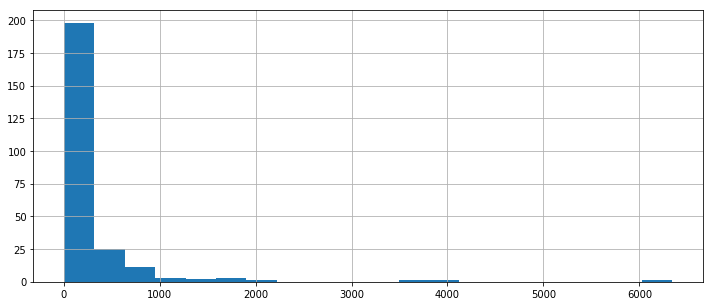

In [59]:
m_predicates_w_lexes_train['size'].hist(bins=20, figsize=(12, 5))

In [69]:
# one example of a predicate lexicalized less than 10 times
m_predicates_w_lexes_train_size_lt_5 = m_predicates_w_lexes_train[m_predicates_w_lexes_train['size'] < 10]

print_m_predicate_with_generated_lexes(m_predicates_w_lexes_train_size_lt_5.sample().iloc[0, :])

m_predicate:  foundingDate 

lexicalization:  14th New Jersey Volunteer Infantry Monument was founded 1907-07-11. 

lexicalization:  A memorial in honour of the 14th New Jersey Volunteer Infantry was founded on 11th July, 1907. The monument is located in the Monocacy National Battlefield, which owned by the National Parks service, is near Frederick, Maryland. 

lexicalization:  The 14th New Jersey Volunteer Infantry Monument was started on 11th July 1907. 

lexicalization:  The 14th New Jersey Volunteer Infantry Monument's founding date was on 1907-07-11. 

lexicalization:  The city of Frederick, Maryland is the nearest city to the Monocacy National Battlefield where the 14th New Jersey Volunteer Infantry monument is located. The founding date of the memorial was 11 July 1907 and is looked after by the National Park Service. 

lexicalization:  The memorial depicting the 14th New Jersey Volunteer Infantry was founded on July 11th, 1907. 



In [73]:
# one example of a predicate lexicalized more than 6k times
m_predicates_w_lexes_train_size_lt_5 = m_predicates_w_lexes_train[m_predicates_w_lexes_train['size'] > 6000]

print_m_predicate_with_generated_lexes(m_predicates_w_lexes_train_size_lt_5.sample().iloc[0, :])

m_predicate:  country 

lexicalization:  " A Wizard of Mars was Published in the United States ". 

lexicalization:  " A Wizard of Mars was Published in the United States, of which English is the language. 

lexicalization:  "A Wizard of Mars" was published in the United States, where the leader is known as the President. 

lexicalization:  "A Wizard of Mars" was published in the United States, where the official language is English. 

lexicalization:  "Adisham Hall is located in Haputale which is in Sri Lanka and the capital of Sri Lanka is Sri JayawRdenepura Kotte and Ranil Wickremesinghe is a leader of Sri Lanka. Sri Lanka's currency is the Ski Lankan rupee.". 

lexicalization:  "Ampara Hospital is in Sri Lanka and is situated in the Eastern Province state of Sri Lanka. Austin Fernando is the leader of the Eastern Province of Sri Lanka and the Eastern Provincial Council is the governing body of Eastern Province, Sri Lanka. Sri Jayawardenepura Kotte is the capital of Sri Lanka.". 

l


lexicalization:  Abu Zahar Ujang is the leader of Malaysia where one of the local foods is asam pedas. 

lexicalization:  Abu Zahar Ujang is the leader of Malaysia. An ethnic group there are the Malaysian Chinese. Asam pedas is a food found in that country. 

lexicalization:  Abu Zahar Ujang is the leader of Malaysia. Malaysian Chinese is an ethnic grop from Malaysia and one of the other ethnic groups of Malaysia is Malaysian Indian. Asam pedas is from the Malay Peninsula region and is a food that is found in Malaysia. 

lexicalization:  Accademia di Architettura de Mendrisio in Mendrisio, Switzerland, which has Meride as its neighboring municipality. The Federal Chancellor of the country is Johann Schneider-Ammann and the country is governed by a Federal Assembly. 

lexicalization:  Accademia di Architettura di Mendrisio in Mendrisio, Switzerland has 100 employees, 600 students and was established in 1996. The country is led by Johann Schneider-Ammann. 

lexicalization:  Accademia di

lexicalization:  Ampara Hospital is in Eastern Province, Sri Lanka where the leader is Austin Fernando. Sri Jayawardenepura Kotte is the capital of the country. 

lexicalization:  Ampara Hospital is in Eastern Province, Sri Lanka which is lead by Austin Fernando. The leader of Sri Lanka is Ranil Wickremesinghe. 

lexicalization:  Ampara Hospital is in Eastern Province, Sri Lanka, where Austin Fernando is a key leader. Sri Jayawardenepura Kotte is the capital of Sri Lanka, where the Sri Lankan rupee is used as currency. 

lexicalization:  Ampara Hospital is in Eastern Province, Sri Lanka, where the Eastern Provincial Council is the governing body. Austin Fernando is the leader of the Eastern Province, and the leader of Sri Lanka is Ranil Wickremesinghe. 

lexicalization:  Ampara Hospital is in Eastern Province, Sri Lanka. Ranil Wickremesinghe is a leader there. 

lexicalization:  Ampara Hospital is in Eastern Province, a part of Sri Lanka. 

lexicalization:  Ampara Hospital is in Sri La

lexicalization:  Bacon and sausage are the main ingredients of a Bacon Explosion which originates from the United States. 

lexicalization:  Bacon and sausage can be found in the Bacon Explosion that comes from the United States. It is worthy of a main course in the Kansas City Metropolitan area. 

lexicalization:  Bacon explosion comes from the United States which is lead by Joe Biden. The capital city is Washington DC and one of the ethnic groups in the country are the native Americans. 

lexicalization:  Bacon explosion comes from the United States, where Barack Obama is a leader and where Native Americans are an ethnic group. 

lexicalization:  Bacon explosion comes from the United States, where Paul Ryan is a leader and white Americans are an ethnic group. The capital of the US is Washington DC and the leader of the United States is called the President. 

lexicalization:  Bacon explosion is a dish from the United States, where African Americans are an ethnic group. 

lexicalizati


lexicalization:  Bionico is a food found in Mexico, where the leader is Silvano Aureoles Conejo and one of the languages spoken is Mexican Spanish. 

lexicalization:  Bionico is a food found in Mexico. 

lexicalization:  Bionico is a food found in Mexico. Mexico's currency is the Peso and a leader in Mexico is Enrique Pena Nieto. 

lexicalization:  Bionico is a food found in Spanish speaking Mexico, a country led by Silvano Aureoles Conejo. 

lexicalization:  Bionico is a food found in mexico, comes from the region of Jalisco and has condensed milk as an ingredient. 

lexicalization:  Bionico is a food found in the Jalisco region of Mexico;its ingredients contain the following: sour cream, chopped fruits, condensed milk. granola, raisins and shredded coconut. 

lexicalization:  Bionico is a food found in the Mexican region of Jalisco, where the leader is Aristoteles Sandoval. Bionico is served as a dessert course, a variation of which is cake. 

lexicalization:  Bionico is a food from

lexicalization:  One of the main ingredients in binignit is banana, originating from the philippines and has taro as an ingredient. 

lexicalization:  One of the main ingredients of Binignit is the sweet potato, whic can be found in the philippines and has Taro as an ingredient. 

lexicalization:  One of the main ingredients of binignit is coconut milk and this dish can be found in the Philippines. 

lexicalization:  One of the main ingredients of the cuisine of Binignit, in the Philippines, is the sweet potato, and another is coconut milk. 

lexicalization:  One of the rivers of India is the Ganges and the country is also the location of the AWH Engineering College which was established in 2001 and located in the city of Kuttikkattoor in the state of Kerala. 

lexicalization:  One of the rivers of India is the Ganges. The country is also the location of the AWH Engineering College which has 250 academic staff and is located in the state of Kerala which is southeast of Mahe, India. 

l

lexicalization:  The Allama Iqbal International airport serves the city of Lahore in Pakistan. 

lexicalization:  The American George Winckler was the architect of 320 South Boston Building, of which construction began in 1910. 

lexicalization:  The American Journal of Math (Am. J. Math.) is published in the U.S. by the Johns Hopkins University Press . Johns Hopkins University is the parent company of the Johns Hopkins University Press. 

lexicalization:  The American Journal of Mathematics (ISSN#:0002-9327) is published by the United States' John Hopkins University Press. 

lexicalization:  The American Journal of Mathematics (OCLC number 1480153) is published by the Johns Hopkins University Press which is based in the United States. John Hopkins university Press has the parent company John Hopkins University. 

lexicalization:  The American Journal of Mathematics (abbrv. Am. J. Math) was published by Johns Hopkins University (located: US). It is the parent company of Johns Hopkins U

lexicalization:  The main ingredients of Bandeja paisa are red beans, pork belly, white rice, ground meat, chicharon, fried egg, plantain (patacones), chorizo, arepa, hogao sauce, black pudding (morcilla), avocado and lemon. The dish is part of Colombian cuisine and comes from the Antioquia department. 

lexicalization:  The main ingredients of Bandeja paisa are: red beans, pork belly, white rice, ground meat, chicharon, fried egg, plantain (patacones), chorizo, arepa, hogao sauce, black pudding (morcilla), avocado and lemon. The dish is part of Colombian cuisine from the Antioquia Department. 

lexicalization:  The main ingredients of Bandeja paisa are: red beans, pork belly, white rice, ground meat, chicharon, fried egg, plantain (patacones), chorizo, arepa, hogao sauce, black pudding (morcilla), avocado and lemon. The dish originates from the Paisa region of Colombia. 

lexicalization:  The main ingredients of Bandeja paisa, a dish from the Paisa region of Colombia, are: red beans, 

## Number of distinct subjects, predicates, objects

### for each dataset

In [74]:
def report_n_distinct_s_p_o(mdf):
    
    return {'subject': mdf.m_subject.nunique(),
            'predicate': mdf.m_predicate.nunique(),
            'object': mdf.m_object.nunique(),
            # defined as a subject ou object
            'subject_and_object': pd.concat([mdf.m_subject, mdf.m_object]).nunique(),
            # vocabulary size
            'vocabulary': pd.concat([mdf.m_subject, mdf.m_object, mdf.m_predicate]).nunique()
           }

In [75]:
df = pd.DataFrame(data = [report_n_distinct_s_p_o(ds.mdf) for ds in datasets],
             index = [ds.dataset for ds in datasets])

df['unique_triples'] = [ds.mdf.mtext.nunique() for ds in datasets]
df

,object,predicate,subject,subject_and_object,vocabulary,unique_triples
train_dev,1642,246,434,1771,2017,2131
test_no_lex,1888,300,575,2125,2425,2331
test_unseen_with_lex,898,159,238,1002,1161,1068


### among all datasets

In [76]:
pd.DataFrame(report_n_distinct_s_p_o(pd.concat([ds.mdf for ds in datasets])),
             index=['all'])

,object,predicate,subject,subject_and_object,vocabulary
all,2505,354,667,2730,3084


## Most frequent subjects, predicates, objects

in relation to amount of entries in which they occur, not the amount of lexicalizations where they appear(remember that an entry can have more than one lexicalization)

In [77]:
def most_frequent(ds, type_, n=5):
    
    if type_ == 'subject':
        return ds.mdf.m_subject.value_counts().nlargest(n)
    if type_ == 'object':
        return ds.mdf.m_object.value_counts().nlargest(n)
    if type_ == 'predicate':
        return ds.mdf.m_predicate.value_counts().nlargest(n)

### train_dev

In [78]:
most_frequent(train_dev, 'subject')

United_States                      760
Acharya_Institute_of_Technology    539
Alan_Shepard                       478
Elliot_See                         474
Alan_Bean                          410
Name: m_subject, dtype: int64

In [79]:
most_frequent(train_dev, 'object')

United_States       944
English_language    294
Indonesia           185
Spain               169
Italy               142
Name: m_object, dtype: int64

In [80]:
most_frequent(train_dev, 'predicate')

country       2409
location      1537
leaderName    1385
ingredient     738
isPartOf       641
Name: m_predicate, dtype: int64

## Distribution of vocabulary

### m_subject

In [81]:
m_subject_vc = train_dev.mdf.m_subject.value_counts()

m_subject_vc.describe(percentiles=[.5, .75, .9, .99])

count    434.000000
mean      53.043779
std       79.166678
min        1.000000
50%       20.000000
75%       79.750000
90%      124.000000
99%      409.670000
max      760.000000
Name: m_subject, dtype: float64

* 50% dos m_subject ocorrem 20 ou menos vezes
* 50% dos m_subject ocorrem 21 ou mais vezes

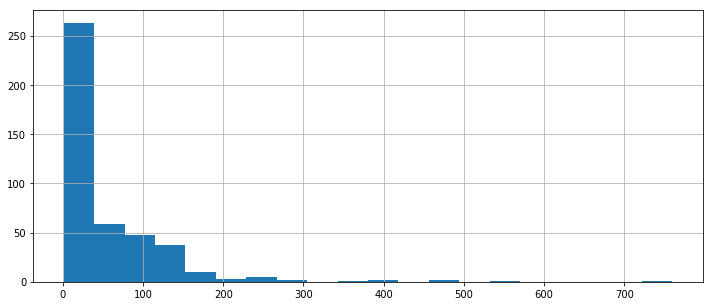

In [82]:
m_subject_vc.hist(bins=20, figsize=(12, 5))

### m_predicate

In [84]:
m_predicate_vc = train_dev.mdf.m_predicate.value_counts()

m_predicate_vc.describe(percentiles=[.5, .75, .9, .99])

count     246.000000
mean       93.581301
std       228.610263
min         1.000000
50%        25.000000
75%        80.000000
90%       228.000000
99%      1093.850000
max      2409.000000
Name: m_predicate, dtype: float64

* 50% dos m_predicate ocorrem 25 ou menos vezes
* 50% dos m_predicate ocorrem 26 ou mais vezes

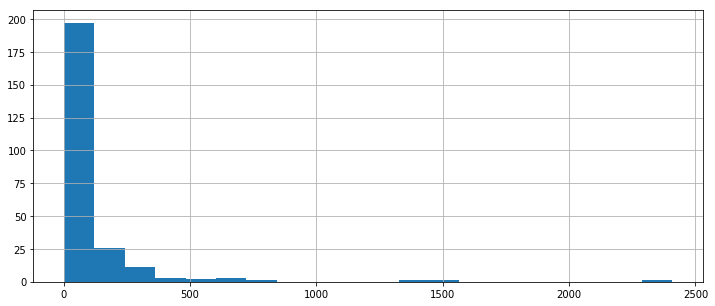

In [85]:
m_predicate_vc.hist(bins=20, figsize=(12, 5))

### m_object

In [86]:
m_object_vc = train_dev.mdf.m_object.value_counts()

m_object_vc.describe(percentiles=[.5, .75, .9, .99])

count    1642.000000
mean       14.020097
std        30.023659
min         1.000000
50%         7.000000
75%        16.000000
90%        31.000000
99%        93.180000
max       944.000000
Name: m_object, dtype: float64

* 50% dos m_object ocorrem 7 ou menos vezes
* 50% dos m_object ocorrem 8 ou mais vezes

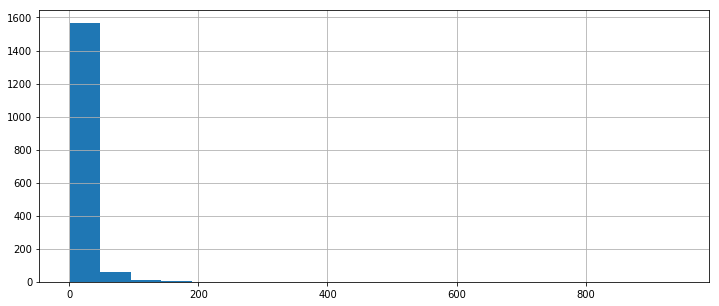

In [87]:
m_object_vc.hist(bins=20, figsize=(12, 5))

# Is tripleset connected?

is there a path between any pair of triples?

## Let's check a sample

### non connected example

This example looks like a case of verbalization containing more information than data!

Triple info: {'category': 'Food', 'eid': 'Id186', 'idx': '25_185', 'ntriples': 4}

	Modified triples:

Batagor | country | Indonesia
Siomay | dishVariation | Shumai
Shumai | dishVariation | Siomay
Batagor | ingredient | Peanut_sauce


	Lexicalizations:

Batagor comes from Indonesia, it includes peanut sauce and is a variation on Shumai/Siomay.
Shumai is a variation of Siomay and they are both types of the same dish. Batagor is found in Indonesia and has peanut sauce as an ingredient.
Batagor, a variant of Shumai and Siomay, contains peanut sauce and originates from Indonesia.


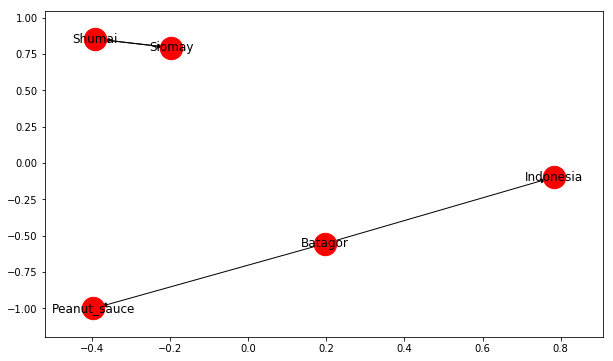

In [47]:
s = train_dev.sample(idx='25_185')

print(s)
s.draw_graph()

### connected example

Triple info: {'category': 'Food', 'eid': 'Id101', 'idx': '25_100', 'ntriples': 4}

	Modified triples:

Bacon_sandwich | dishVariation | BLT
BLT | dishVariation | Club_sandwich
Bacon_sandwich | ingredient | Condiment
Bacon_sandwich | country | United_Kingdom


	Lexicalizations:

The country that bacon sandwich comes from is the United Kingdom. It can be served with condiments and variations include the BLT and club sandwich.
Bacon sandwich is a dish from the United Kingdom and condiments are used to prepare it.BLT is a variation of a Club Sandwich.
The BLT is a bacon sandwich, a variant of the Club sandwich. The bacon sandwich uses condiments and originates from the United Kingdom.


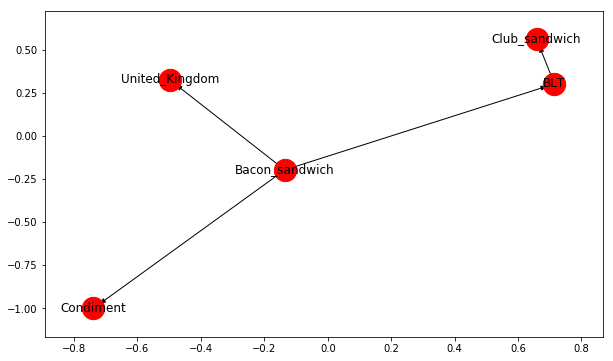

In [48]:
s = train_dev.sample(idx='25_100')

print(s)
s.draw_graph()

## Let's check all tripleset

In [51]:
import networkx as nx

def entries_is_connected_df(mdf):

    is_connected = []

    for idx, entry_group in mdf.groupby('idx'):

        entry_group.reset_index(inplace=True)

        d_g = nx.from_pandas_edgelist(entry_group, 'm_subject', 'm_object', 'm_predicate', create_using=nx.DiGraph())
        u_g = nx.Graph(d_g)

        is_connected.append([idx, nx.is_connected(u_g)])

    is_connected_df = pd.DataFrame(is_connected, columns=['idx', 'is_connected'])
    
    return is_connected_df.is_connected.value_counts()

### train_dev

In [52]:
entries_is_connected_df(train_dev.mdf)

True     7800
False      12
Name: is_connected, dtype: int64

### test_unseen_with_lex

In [53]:
entries_is_connected_df(test_unseen_with_lex.mdf)

True     887
False      4
Name: is_connected, dtype: int64

# Is it possible to determine a 'root' entity?

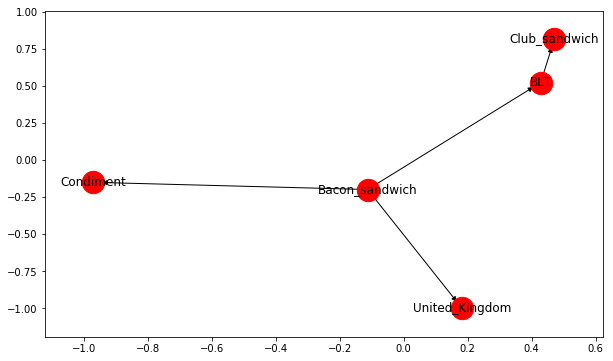

In [54]:
entry = train_dev.sample(idx='25_100')
entry.draw_graph()

In [55]:
sorted(entry.graph.degree, key=lambda x: x[1], reverse=True)

[('Bacon_sandwich', 3),
 ('BLT', 2),
 ('Club_sandwich', 1),
 ('Condiment', 1),
 ('United_Kingdom', 1)]

# Typos

"Afonso Pena International Airport ICAO Location **Idenitifier** is SBCT."

rather than

"Afonso Pena International Airport ICAO Location **Identifier** is SBCT."

In [56]:
test_with_lex = WebNLGCorpus.load(dataset='test_with_lex')

In [57]:
e = test_with_lex.sample(idx='0_3')
e

Triple info: {'category': 'Airport', 'eid': 'Id4', 'idx': '0_3', 'ntriples': 1}

	Modified triples:

Afonso_Pena_International_Airport | ICAO_Location_Identifier | "SBCT"


	Lexicalizations:

Afonso Pena International Airport ICAO Location Idenitifier is SBCT.
SBCT is the ICAO location identifier of Afonso Pena International Airport.

In [58]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

s_multiwordexpressions = test_with_lex.mdf.m_subject.str.lower().str.replace('_', ' ').str.split().tolist()
o_multiwordexpressions = test_with_lex.mdf.m_object.str.lower().str.replace('_', ' ').str.split().tolist()

all_multiwordexpressions = s_multiwordexpressions + o_multiwordexpressions
all_multiwordexpressions = list(set([tuple(s) for s in all_multiwordexpressions]))

from nltk.tokenize.mwe import MWETokenizer

t = MWETokenizer(all_multiwordexpressions)

from textacy.preprocess import preprocess_text

def preprocess(ref):
    
    ref = preprocess_text(ref, no_accents=True, lowercase=True, no_punct=True)
    
    return t.tokenize(ref.split())

cc = SmoothingFunction()
def bleu(e, text):
    
    references = [preprocess(ref) for ref in e.ldf.ltext.tolist()]

    # TODO: same smoothing as Moses?
    return sentence_bleu(references, preprocess(text), smoothing_function=cc.method3)

In [59]:
bleu(e, 'Afonso Pena International Airport ICAO Location Identifier is SBCT.')

0.5081327481546147

In [60]:
bleu(e, 'Afonso Pena International Airport ICAO Location Idenitifier is SBCT.')

1.0